In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from scipy.signal import find_peaks
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [94]:
def load_pred(pred_dir, ct, chrom, pred_len=200, avg_stripe=False):
    file = osp.join(pred_dir, ct, 'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    chrom_len = temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array([
        np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)
    ])
    summed = np.vstack((
        np.zeros((pred_len, mat.shape[1])), mat
    )).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack((
            np.zeros((pred_len, mat.shape[1])), mat
        ))[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    return summed[pred_len:-pred_len, pred_len:-pred_len]


def set_diagonal(pred, val=0):
    l = pred.shape[0]
    idx = np.arange(l)
    pred[idx[:-1], idx[1:]] = val
    pred[idx[1:], idx[:-1]] = val
    
    return pred


def quantile_norm(pred1, pred2):
    l = pred1.shape[0]
    pred1_diag = np.array([np.pad(np.diagonal(pred1, offset=i), (0, i), 'constant') for i in range(200)]).T
    pred2_diag = np.array([np.pad(np.diagonal(pred2, offset=i), (0, i), 'constant') for i in range(200)]).T
    pred = np.column_stack((pred1_diag.ravel(), pred2_diag.ravel()))
    df, df_sorted = pd.DataFrame(pred), pd.DataFrame(np.sort(pred, axis=0))
    df_mean = df_sorted.mean(axis=1)
    df_mean.index += 1
    df_qn = df.rank(method='min').stack().astype(int).map(df_mean).unstack()
    pred1_stripe, pred2_stripe = df_qn[0].values.reshape(-1,200), df_qn[1].values.reshape(-1,200)
    
    pred1_qn, pred2_qn = np.zeros_like(pred1), np.zeros_like(pred2)
    for i in range(200):
        idx = np.arange(l-i, dtype=int)
        pred1_qn[idx, idx+i] = pred1_qn[idx+i, idx] = pred1_stripe[:l-i, i]
        pred2_qn[idx, idx+i] = pred2_qn[idx+i, idx] = pred2_stripe[:l-i, i]
    
    return pred1_qn, pred2_qn


def quantile_norm_multi(preds):
    return


def topdom(mat, size):
    padmat = np.pad(mat, size, mode='constant', constant_values=np.nan)
    dim = padmat.shape[0]
    signal = np.array([
        np.nanmean(padmat[i-size:i+size, i-size:i+size]) for i in range(dim)
    ][size:-size])
    
    return signal


def generate_dim(mindim, maxdim, numdim):
    mindim, maxdim = max(1, mindim), min(100, maxdim)
    return np.linspace(mindim, maxdim, num=numdim, dtype=int)


def get_tads(mat, sizes):
    signal = np.array([topdom(mat, i) for i in tqdm(sizes)])
    rows, idxs = [], []
    for i in range(len(signal)):
        idx = find_peaks(signal[i], prominence=(0.25, ))[0]
        row = np.full_like(idx, i)
        rows.append(row)
        idxs.append(idx)
    tads = np.array([
        np.concatenate(rows, axis=None), np.concatenate(idxs, axis=None)
    ])
    
    return tads


def tads_to_coords(tads, sizes):
    coords = np.array([
        tads[1] - sizes[tads[0]], tads[1] + sizes[tads[0]]
    ])
    
    return coords


def merge_coords(coords, sizes, close=5):
    df = pd.DataFrame({'x': coords[0], 'y': coords[1]})
    merged = df.groupby('x', as_index=False).agg({'y': 'max'})
    merged['s'] = (merged.y - merged.x) // 2
    merged = merged.sort_values(by=['x']).reset_index(drop=True)
    
    i = 0
    curx, cury, curs = merged.iloc[i]
    
    while i+1 < merged.shape[0]:
        x, y, s = merged.iloc[i+1]
        if s == curs:
            if abs(x - curx) <= close:
                curx, cury = min(curx, x), max(cury, y)
                curs = (cury - curx) // 2
                merged = merged.drop(i+1, axis=0).reset_index(drop=True)
            else:
                curx, cury, curs = x, y, s
                i += 1
        else:
            # if abs(s - curs) <= close*2 and (abs(x - curx) <= close or abs(y - cury) <= close):
            if abs(x - curx) <= close or abs(y - cury) <= close:
                curx, cury = min(curx, x), max(cury, y)
                curs = (cury - curx) // 2
                merged = merged.drop(i+1, axis=0).reset_index(drop=True)
            else:
                curx, cury, curs = x, y, s
                i += 1
        merged.iloc[i] = [curx, cury, curs]
    
    return merged.values.T


def get_tad_coords(mat1, mat2, mindim=10, maxdim=100, numdim=10, close=5):
    sizes = generate_dim(mindim, maxdim, numdim)
    tads1, tads2 = get_tads(mat1, sizes), get_tads(mat2, sizes)
    alltads = np.concatenate((tads1, tads2), axis=1)
    allcoords = tads_to_coords(alltads, sizes)
    coords = merge_coords(allcoords, sizes, close)
    
    return coords


def rank_coords(mat1, mat2, coords):
    xs, ys, ss, scores, absscores = [], [], [], [], []
    for i in range(coords.shape[1]):
        x, y, s = coords[:, i]
        area1, area2 = mat1[x:y, x:y], mat2[x:y, x:y]
        area_diff = area1 - area2
        score = np.mean(area_diff)
        absscore = np.std(area_diff) * np.ptp(area_diff)
        xs.append(x)
        ys.append(y)
        ss.append(s)
        scores.append(score)
        absscores.append(absscore)
    df = pd.DataFrame({
        'x_coord': xs, 'y_coord': ys, 'window_size': ss,
        'diff_direction': scores, 'abs_diff_score': absscores
    })
    df = df.sort_values(by=['abs_diff_score'], ignore_index=True, ascending=False)
    
    return df

In [55]:
%%time

chrom = 6
pred_dir = '/data/leslie/suny4/predictions/chromafold/'
ct1 = 'mycGCB_am_gfp_myc_gcb_thelp_sample'
ct2 = 'mycGCB_am_gfp_myc_gcb_nothelp_sample'

pred1 = load_pred(pred_dir, ct1, chrom, avg_stripe=True)
pred2 = load_pred(pred_dir, ct2, chrom, avg_stripe=True)
pred1, pred2 = set_diagonal(pred1), set_diagonal(pred2)
pred1_qn, pred2_qn = quantile_norm(pred1, pred2)

CPU times: user 9.57 s, sys: 6.22 s, total: 15.8 s
Wall time: 15.9 s


In [95]:
coords = get_tad_coords(pred1_qn, pred2_qn, mindim=25, maxdim=75, numdim=5, close=20)
ranked = rank_coords(pred1_qn, pred2_qn, coords)

100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


In [96]:
ranked.head()

,x_coord,y_coord,window_size,diff_direction,abs_diff_score
0,5457,5509,26,0.172764,2.458462
1,6656,6731,37,0.342459,1.867022
2,2916,3047,65,-0.186065,1.771002
3,9964,10089,62,0.183234,1.688800
4,2974,3126,76,-0.146418,1.684862


In [97]:
ranked.tail()

,x_coord,y_coord,window_size,diff_direction,abs_diff_score
95,4299,4423,62,0.078950,0.195274
96,4213,4266,26,-0.016480,0.145023
97,13092,13166,37,-0.071613,0.125481
98,6075,6149,37,-0.051525,0.122243
99,5688,5762,37,0.140402,0.116765


5457, 5509, 26, 0.173, 2.458


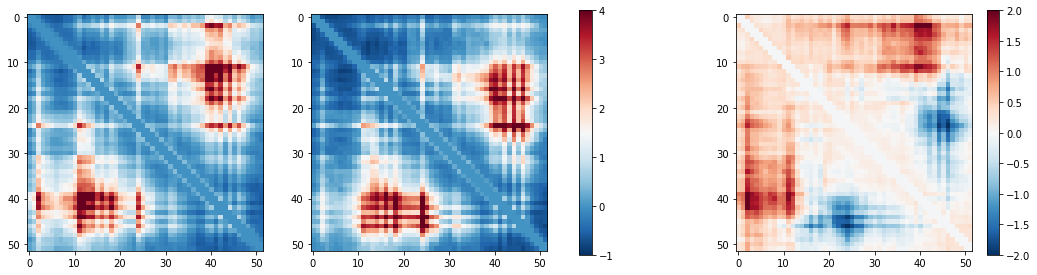

6656, 6731, 37, 0.342, 1.867


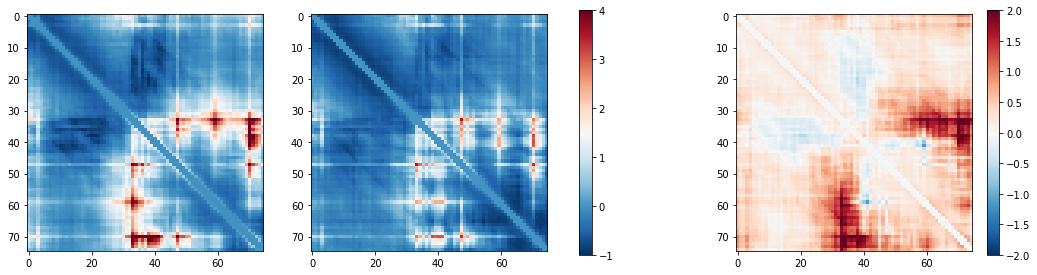

2916, 3047, 65, -0.186, 1.771


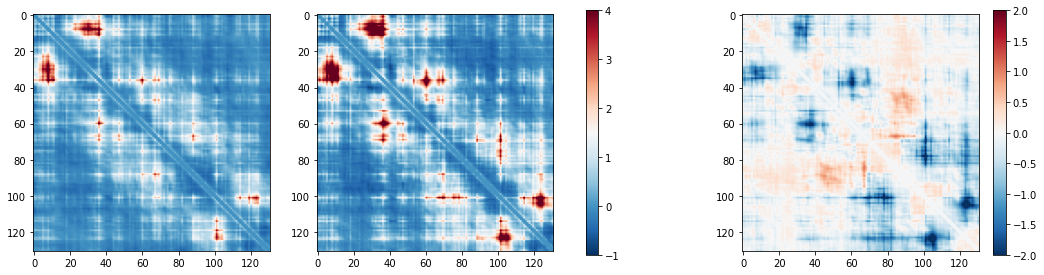

9964, 10089, 62, 0.183, 1.689


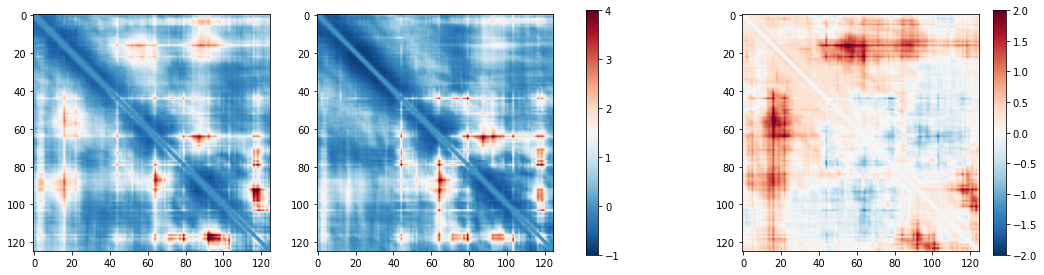

2974, 3126, 76, -0.146, 1.685


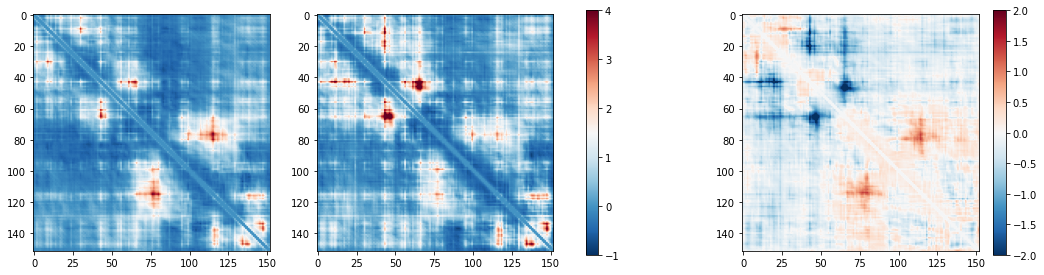

In [98]:
for i in range(5):
    x, y, s, score1, score2 = ranked.iloc[i]
    x, y, s = int(x), int(y), int(s)
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    print(f'{x}, {y}, {s}, %.3f, %.3f' % (score1, score2))
    area1, area2 = pred1_qn[x:y, x:y], pred2_qn[x:y, x:y]
    area_diff = area1 - area2
    im = axs[0].imshow(area1, cmap='RdBu_r', vmax=4, vmin=-1)
    im = axs[1].imshow(area2, cmap='RdBu_r', vmax=4, vmin=-1)
    fig.colorbar(im, ax=axs[:2].ravel().tolist(), shrink=0.75)
    im = axs[2].imshow(area_diff, cmap='RdBu_r', vmax=2, vmin=-2)
    fig.colorbar(im, ax=axs[2], shrink=0.75)
    
    plt.show()

4299, 4423, 62, 0.079, 0.195


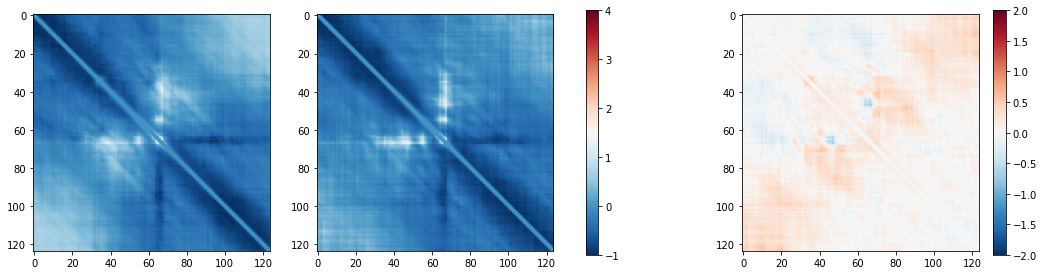

4213, 4266, 26, -0.016, 0.145


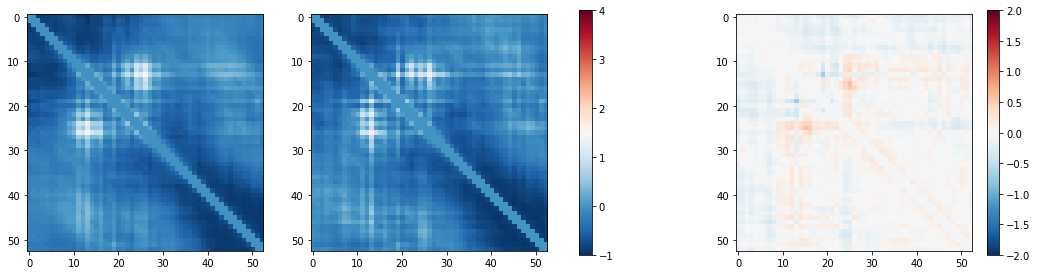

13092, 13166, 37, -0.072, 0.125


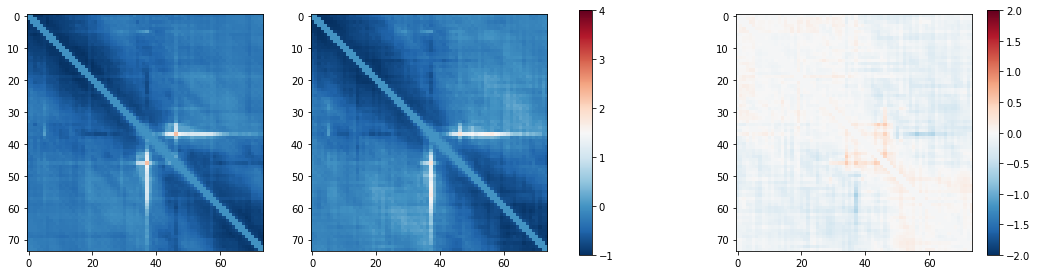

6075, 6149, 37, -0.052, 0.122


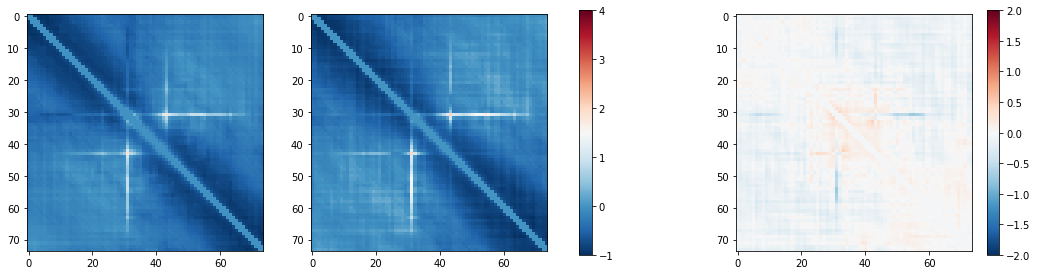

5688, 5762, 37, 0.140, 0.117


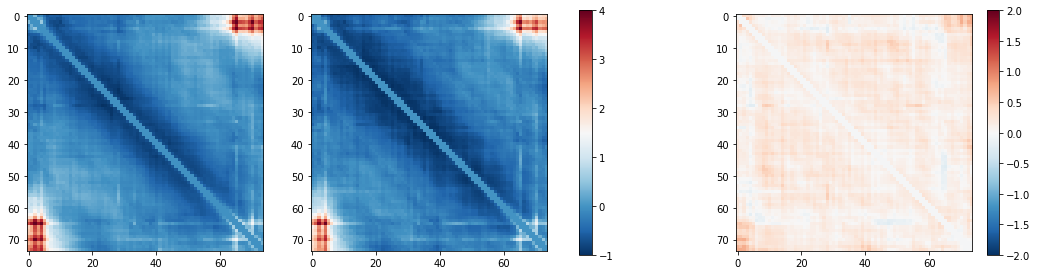

In [99]:
for i in range(-5, 0):
    x, y, s, score1, score2 = ranked.iloc[i]
    x, y, s = int(x), int(y), int(s)
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    print(f'{x}, {y}, {s}, %.3f, %.3f' % (score1, score2))
    area1, area2 = pred1_qn[x:y, x:y], pred2_qn[x:y, x:y]
    area_diff = area1 - area2
    im = axs[0].imshow(area1, cmap='RdBu_r', vmax=4, vmin=-1)
    im = axs[1].imshow(area2, cmap='RdBu_r', vmax=4, vmin=-1)
    fig.colorbar(im, ax=axs[:2].ravel().tolist(), shrink=0.75)
    im = axs[2].imshow(area_diff, cmap='RdBu_r', vmax=2, vmin=-2)
    fig.colorbar(im, ax=axs[2], shrink=0.75)
    
    plt.show()

In [100]:
ranked

,x_coord,y_coord,window_size,diff_direction,abs_diff_score
0,5457,5509,26,0.172764,2.458462
1,6656,6731,37,0.342459,1.867022
2,2916,3047,65,-0.186065,1.771002
3,9964,10089,62,0.183234,1.688800
4,2974,3126,76,-0.146418,1.684862
...,...,...,...,...,...
95,4299,4423,62,0.078950,0.195274
96,4213,4266,26,-0.016480,0.145023
97,13092,13166,37,-0.071613,0.125481
98,6075,6149,37,-0.051525,0.122243


In [127]:
temp = np.zeros(pred1_qn.shape[0])
for i in range(ranked.shape[0]):
    x, y, _, diff_dir, abs_diff = ranked.iloc[i]
    x, y = int(x), int(y)
    temp[x:y+1] = np.maximum(temp[x:y+1], np.full(y+1-x, abs_diff), out=temp[x:y+1])

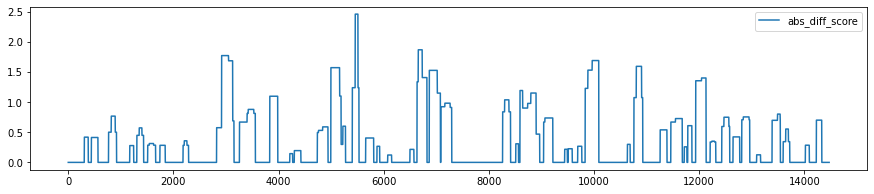

In [128]:
plt.figure(figsize=(15, 3))
plt.plot(temp, label='abs_diff_score')
plt.legend()
plt.show()

In [118]:
temp = np.zeros((2, pred1_qn.shape[0]))
for i in range(ranked.shape[0]):
    x, y, _, diff_dir, abs_diff = ranked.iloc[i]
    x, y = int(x), int(y)
    for j in range(x, y+1):
        if not temp[0][j]:
            temp[:,j] = [abs_diff, diff_dir]

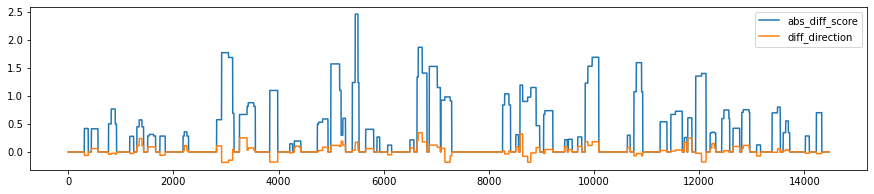

In [119]:
plt.figure(figsize=(15, 3))
plt.plot(temp[0], label='abs_diff_score')
plt.plot(temp[1], label='diff_direction')
plt.legend()
plt.show()

In [120]:
temp[0]

array([0., 0., 0., ..., 0., 0., 0.])

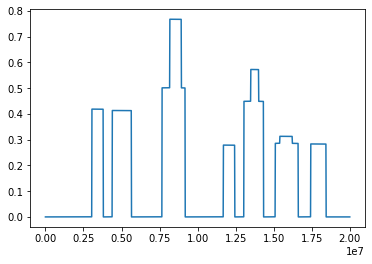

In [126]:
def interpolate(signal, bin_size=10000, pattern='smooth'):
    if pattern is None: return signal
    if pattern not in ['smooth', 'zigzag']:
        raise ValueError(
            'Bad parameter, expecting \'smooth\' or \'zigzag\' but got \'{}\''.format(pattern)
        )
    if pattern=='smooth':
        l = len(signal) * bin_size
        sparse, compact = np.linspace(0, l, len(signal)), np.linspace(0, l, l)
        interp_signal = np.interp(compact, sparse, signal)
    else:
        interp_signal = np.tile(signal, (bin_size, 1)).flatten('F')
    
    return interp_signal

plt.plot(interpolate(temp[0])[:20000000])
plt.show()